In [1]:
import pandas as pd
import numpy as np
import powerlaw
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
df = pd.read_csv('videogames.csv')  # Read raw data
df.head()                           # First 5 rows in data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('The data set includes {} unique Publishers'.format(df['Publisher'].nunique()))
print('The data set includes {} unique Developers'.format(df['Developer'].nunique()))
print('The data set includes {} genres'.format(df['Genre'].nunique()))
print('The data set includes {} platforms'.format(df['Platform'].nunique()))

The data set includes 581 unique Publishers
The data set includes 1696 unique Developers
The data set includes 12 genres
The data set includes 31 platforms


In [4]:
df.info()  # Raw info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [5]:
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')*10 # Convert User Score to double and normalize it to match Critic Score
df = df.dropna(axis=0, how='any')  # Eliminate rows if they contain any NaN value
df.info()                          # Info without NaN values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
Name               6825 non-null object
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Other_Sales        6825 non-null float64
Global_Sales       6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null float64
User_Count         6825 non-null float64
Developer          6825 non-null object
Rating             6825 non-null object
dtypes: float64(10), object(6)
memory usage: 906.4+ KB


In [6]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,71.856264,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,14.399417,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75.000000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,82.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


### Scores

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


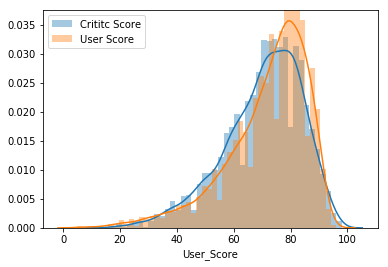

In [7]:
newdf = df[['Critic_Score', 'User_Score']].dropna(axis=0)
sns.distplot(newdf['Critic_Score'], label='Crititc Score')
sns.distplot(newdf['User_Score'], label='User Score')
plt.legend()
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


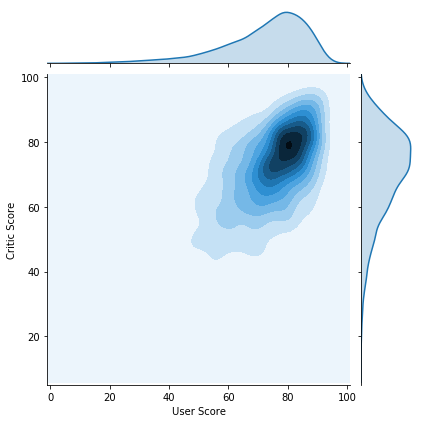

In [8]:
plot = sns.jointplot(x="User_Score", y="Critic_Score", data=newdf, kind="kde", stat_func=None, xlim=(-1,101), ylim=(5,101))
plot.set_axis_labels('User Score', 'Critic Score')

### Popular Genre

      Action has 1203.16 million sales and 1630 entries in the database
      Sports has  833.85 million sales and  943 entries in the database
     Shooter has  816.48 million sales and  864 entries in the database
Role-Playing has  501.37 million sales and  712 entries in the database
      Racing has  476.22 million sales and  581 entries in the database
    Platform has  377.80 million sales and  403 entries in the database
    Fighting has  249.95 million sales and  378 entries in the database
  Simulation has  202.70 million sales and  297 entries in the database
   Adventure has   80.75 million sales and  248 entries in the database
      Puzzle has   78.90 million sales and  118 entries in the database
    Strategy has   69.61 million sales and  267 entries in the database
        Misc has  416.26 million sales and  384 entries in the database


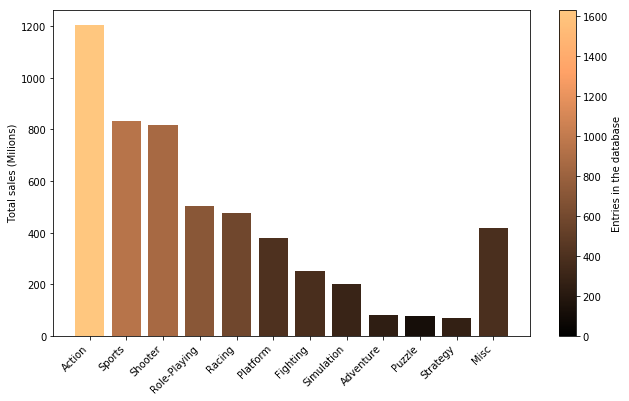

In [9]:
genres =['Action', 'Sports', 'Shooter', 'Role-Playing', 'Racing', 'Platform',
         'Fighting', 'Simulation', 'Adventure', 'Puzzle', 'Strategy', 'Misc']

genres = sorted(genres, key=lambda g: np.sum(df['Global_Sales'][df['Genre'] == g]), reverse=True)
genres.remove('Misc')
genres.append('Misc')

sales = [np.sum(df['Global_Sales'][df['Genre'] == genre]) for genre in genres]
count = np.array([df['Genre'].value_counts()[genre] for genre in genres])

for genre in genres:
    print('{:>12} has {:>7.2f} million sales and {:>4} entries in the database'.format(
           genre,
           np.sum(df['Global_Sales'][df['Genre'] == genre]),
           df['Genre'].value_counts()[genre]))
    
plt.figure(figsize=(16/1.5,6))
    
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=count.max())
colormap = plt.get_cmap('copper')

# setup the colorbar
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(count)
plt.colorbar(scalarmappaple, label = 'Entries in the database')

plt.bar(range(len(genres)), sales, tick_label=genres, color=colormap(normalize(count)))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total sales (Milions)')
plt.show()

### Popular Platform

 PS2 has  945.97 million sales and 1140 entries in the database
X360 has  853.30 million sales and  858 entries in the database
 PS3 has  784.30 million sales and  769 entries in the database
 Wii has  658.98 million sales and  479 entries in the database
  DS has  382.33 million sales and  464 entries in the database
 PS4 has  243.03 million sales and  239 entries in the database
  XB has  212.07 million sales and  565 entries in the database
  PS has  206.55 million sales and  150 entries in the database
 PSP has  187.92 million sales and  390 entries in the database
  PC has  187.12 million sales and  651 entries in the database
  GC has  159.42 million sales and  348 entries in the database
 GBA has  131.75 million sales and  237 entries in the database
XOne has  129.57 million sales and  159 entries in the database
 3DS has  123.23 million sales and  155 entries in the database
WiiU has   66.08 million sales and   89 entries in the database
 PSV has   30.88 million sales and  118 

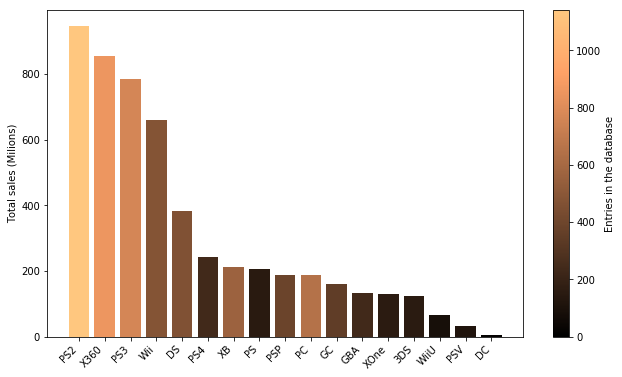

In [10]:
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'XB', 'PS', 'PSP', 'PC',
            'GC', 'GBA', 'XOne', '3DS', 'WiiU', 'PSV', 'DC']

platforms = sorted(platforms, key=lambda p: np.sum(df['Global_Sales'][df['Platform'] == p]), reverse=True)

sales = [np.sum(df['Global_Sales'][df['Platform'] == platform]) for platform in platforms]
count = np.array([df['Platform'].value_counts()[platform] for platform in platforms])

for platform in platforms:
    print('{:>4} has {:>7.2f} million sales and {:>4} entries in the database'.format(
           platform,
           np.sum(df['Global_Sales'][df['Platform'] == platform]),
           df['Platform'].value_counts()[platform]))
    
plt.figure(figsize=(16/1.5,6))
    
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=count.max())
colormap = plt.get_cmap('copper')

# setup the colorbar
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(count)
plt.colorbar(scalarmappaple, label = 'Entries in the database')

plt.bar(range(len(platforms)), sales, tick_label=platforms, color=colormap(normalize(count)))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total sales (Milions)')
plt.show()

### Years

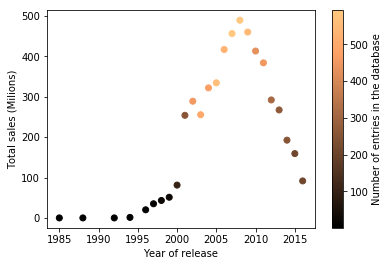

In [11]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = []

for y in years:
    sales.append(np.sum(df['Global_Sales'][df['Year_of_Release'] == y]))

counts = df['Year_of_Release'].value_counts()
colors = [counts[i] for i in years]

plt.set_cmap('copper')
plt.scatter(years, sales, c=colors)
cb = plt.colorbar()
plt.xlabel('Year of release')
plt.ylabel('Total sales (Milions)')
cb.set_label('Number of entries in the database')
plt.show()

### Region wise sales

In [12]:
def func(x):
    a = zip(x.index, x.values)
    a = np.array(sorted(a))
    return a[:,0], np.cumsum(a[:,1])/len(df)

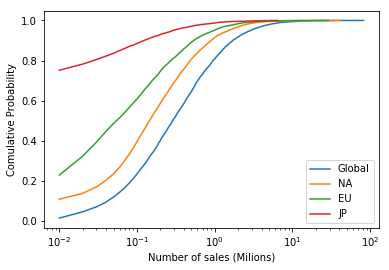

In [13]:
x = df['Global_Sales'].value_counts()
plt.plot(*func(x), label='Global')
x = df['NA_Sales'].value_counts()
plt.plot(*func(x), label='NA')
x = df['EU_Sales'].value_counts()
plt.plot(*func(x), label='EU')
x = df['JP_Sales'].value_counts()
plt.plot(*func(x), label='JP')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.ylabel('Comulative Probability')
plt.xlabel('Number of sales (Milions)')
plt.show()

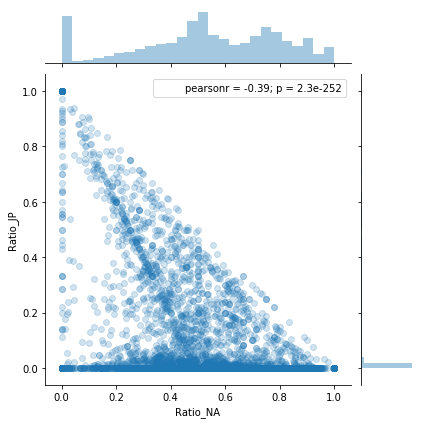

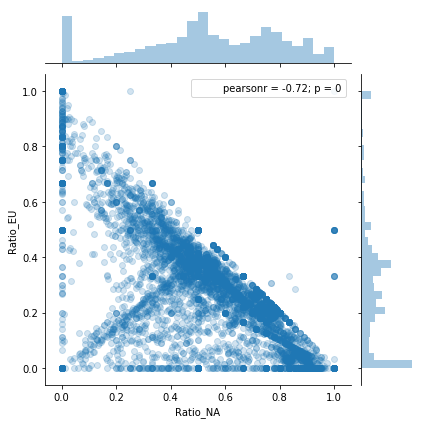

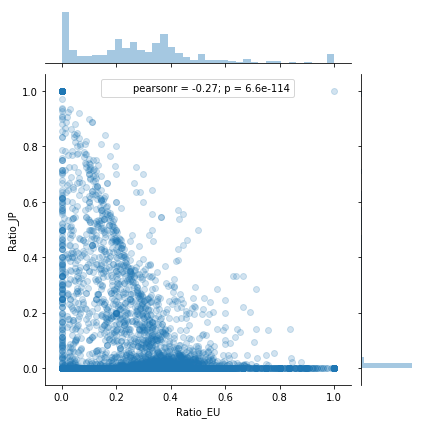

In [14]:
df['Ratio_NA'] = df['NA_Sales']/df['Global_Sales']
df['Ratio_EU'] = df['EU_Sales']/df['Global_Sales']
df['Ratio_JP'] = df['JP_Sales']/df['Global_Sales']
df['Ratio_Other'] = df['Other_Sales']/df['Global_Sales']
sns.jointplot(x="Ratio_NA", y="Ratio_JP", data=df, alpha=0.2)
sns.jointplot(x="Ratio_NA", y="Ratio_EU", data=df, alpha=0.2)
sns.jointplot(x="Ratio_EU", y="Ratio_JP", data=df, alpha=0.2)

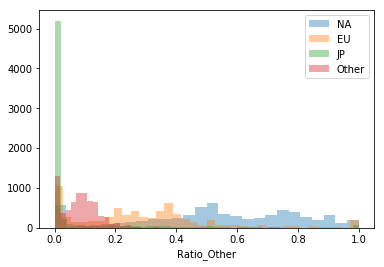

In [15]:
sns.distplot(df['Ratio_NA'], label='NA', kde=False)
sns.distplot(df['Ratio_EU'], label='EU', kde=False)
sns.distplot(df['Ratio_JP'], label='JP', kde=False)
sns.distplot(df['Ratio_Other'], label='Other', kde=False)
plt.legend()
plt.show()

### Shit

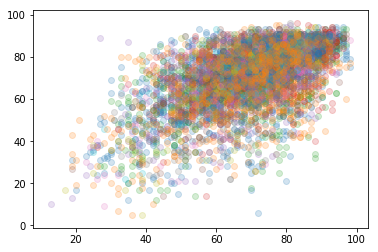

In [16]:
for g in genres:
    plt.scatter(df['Critic_Score'][df['Genre'] == g], df['User_Score'][df['Genre'] == g], alpha=0.2)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
#df = df[df['Rating'] != 'AO']
#df = df[df['Rating'] != 'K-A']
#df = df[df['Rating'] != 'RP']
classes = df['Platform']
dropped = df[['Year_of_Release', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Ratio_NA', 'Ratio_EU', 'Ratio_JP', 'Ratio_Other']]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

LDA = LinearDiscriminantAnalysis(n_components=7)
PCA_ = PCA()
new = PCA_.fit(dropped,classes).transform(dropped)

x_train, x_test, y_train, y_test = train_test_split(dropped,classes,test_size=0.2, random_state=69)

In [18]:
df['Rating'].value_counts()

T       2377
E       2082
M       1433
E10+     930
K-A        1
AO         1
RP         1
Name: Rating, dtype: int64

In [19]:
#print(PCA_.explained_variance_)
#print(PCA_.explained_variance_ratio_)
#print(LDA.explained_variance_ratio_)

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#model = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')
#model = SVC(decision_function_shape='ovr', kernel='linear', verbose=2) #slow and shit
#model = GaussianNB()
#model = RandomForestClassifier(class_weight = 'balanced', criterion='entropy', n_estimators=100, max_features=None, n_jobs=-1)
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, n_jobs=8)
#model = GradientBoostingClassifier(max_depth=6, n_estimators=100)

model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
a = list(zip(dropped.columns,model.feature_importances_))
sorted(a, key=lambda x: x[1], reverse=True)

[('Year_of_Release', 0.12254094),
 ('Ratio_Other', 0.10796532),
 ('User_Count', 0.10349007),
 ('Critic_Count', 0.099605307),
 ('User_Score', 0.092395186),
 ('Ratio_NA', 0.086552508),
 ('Critic_Score', 0.082916372),
 ('Ratio_EU', 0.080523357),
 ('NA_Sales', 0.059638873),
 ('Global_Sales', 0.043726884),
 ('EU_Sales', 0.04021506),
 ('Ratio_JP', 0.033098176),
 ('JP_Sales', 0.027037947),
 ('Other_Sales', 0.020293999)]

0.755311355311
[[ 20   0   0   0   0   0   0   0   2   0   0   1   2   1   6   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0  36   0   0   0   0   1   3   0   5   0  33   0  11   0   0]
 [  0   0   1  39   2   0   0   2   0   0   0   0   0   0   0   8   0]
 [  0   0   1   5  44   0   0   1   0   0   0   0   0   0   0  21   0]
 [  0   0   1   0   0 125   0   1   2   0   0   0   2   0   3   0   1]
 [  0   0   0   2   0   0  30   1   0   0   0   0   0   0   0   0   0]
 [  0   0   3   1   1   0   1 224   0   0   0   0   0   0   0   2   0]
 [  2   0   7   0   0   2   0   0 120   1   3   3   3   0  13   0   0]
 [  0   0   0   0   0   0   0   0   1  37   0   2   0   0   0   0   2]
 [  0   0  16   1   0   0   0   7   4   0  56   0   1   0   4   0   0]
 [  0   0   0   0   0   1   0   0  14   4   0   8   0   0   0   0   0]
 [  2   0  13   0   0   0   0   1   4   0   2   0  44   0  21   0   0]
 [  2   0   0   0   0   1   0   0   2   1   0   0   0  10   3 

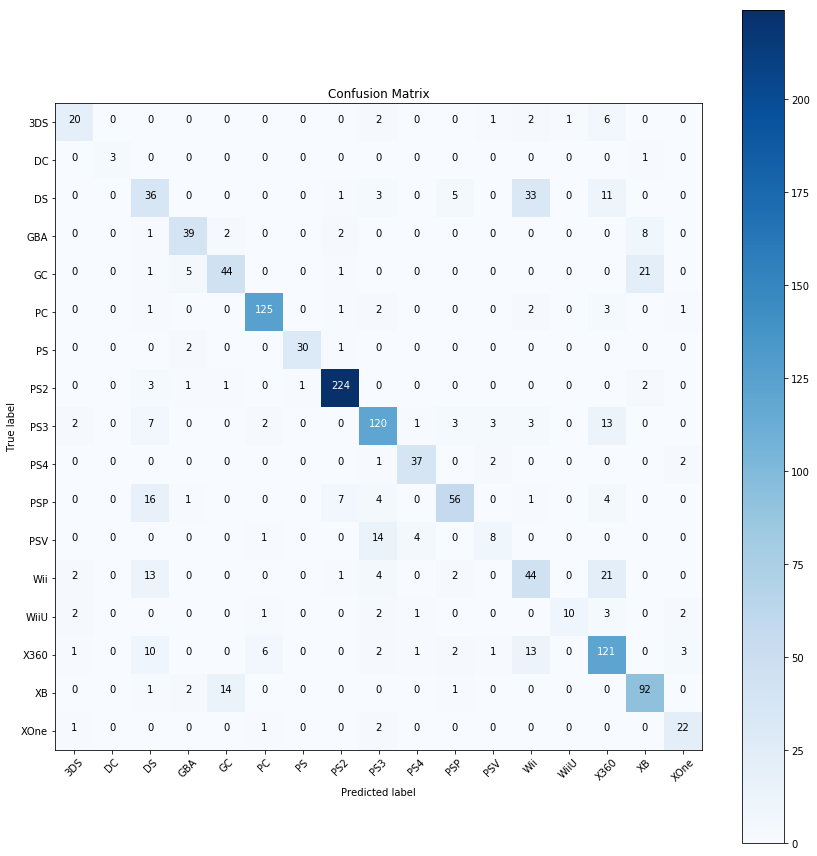

In [22]:
import sys
sys.path.insert(0, '../Data-Mining/')
from tools import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, model.predict(x_test))
print(accuracy_score(y_test, model.predict(x_test)))
print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Confusion Matrix')

In [25]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

model = xgb.XGBClassifier()

random_search = RandomizedSearchCV(model, {'max_depth': list(range(0,3))}, n_iter=3, n_jobs=4, verbose=2, scoring=make_scorer(accuracy_score))

random_search.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=0 .....................................................
[CV] max_depth=0 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=0 .....................................................
[CV] ............................................ max_depth=0 -   2.4s
[CV] max_depth=1 .....................................................
[CV] ............................................ max_depth=0 -   2.5s
[CV] max_depth=1 .....................................................
[CV] ............................................ max_depth=0 -   2.6s
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=1 -   3.3s
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=1 -   3.3s
[CV] max_depth=2 .

[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    6.7s remaining:    1.9s


[CV] ............................................ max_depth=2 -   4.0s
[CV] ............................................ max_depth=2 -   3.9s


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    9.6s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=3, n_jobs=4,
          param_distributions={'max_depth': [0, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(accuracy_score), verbose=2)

### Power Law failled attenpts

In [230]:
results = powerlaw.Fit(data=df['Global_Sales'])
print(results.power_law.alpha)
print(results.power_law.xmin)

2.87655769815
4.19


Calculating best minimal value for power law fit
/usr/local/lib/python3.5/dist-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


191


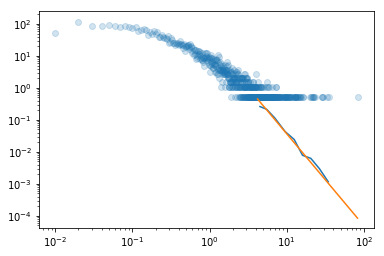

In [237]:
x = df['Global_Sales'].value_counts()
ax = plt.gca()
results.plot_pdf(ax=ax)
results.power_law.plot_pdf(ax=ax)

smallx = x[x.index > results.power_law.xmin]

print(np.sum(smallx.values))

plt.scatter(x.index, x.values/np.sum(smallx.values)*100, alpha=0.2)

#plt.xscale('log')
#plt.yscale('log')
plt.show()